# First Exploration and Tests

This Notebook is a part of the Thesis Project: Learning Multilingual Document Representations.
(Marc Lenz, 2021)

****

It serves the purpose of exploring samples of the relevant Datasets and testing some basic algorithms. 
Step 1 to 5 are very close to the approaches described in Vilmos Thesis. The idea is to first reproduce the results of Vilmos thesis and check if the results are similar (For the fr-en JRC-Arquis). 

Additionally I am aiming to include some additional baselines for the monolingual representations such as Doc2Vec. Also, the linear concept approximation will be extended with some alternative regression methods other than linear least squares approximation.

The steps 6a - 7b will aim to generally extend the usage of concept approximation. The focus will be on transfer learning between different kind of datasets regarding unsupervised and supervised training. 

**Overview:**

**1. Loading and Preprocessing**
- Loading and Preprocessing Data of JRQ-Arquis (Sample, English-French)
- First 2000 Documents are chosen and split into test and training dataset (50:50)
- Planned: Load additional Datasets.

**2. Training of the Monolingual Representations**
- Training some baseline document embeddings using gensim
- So far: Latent Semantic Indexing using different dimensions
- Planned: Additional models such as Doc2Vec, etc.

**3. (Linear) Concept Approximation**
- Implementing a basic Concept approximation function, which maps document representations from one language to another
- So far: Linear Regression using linear least squares
- Planned:  Models using neural networks, optimized with gradient descent. 
- Also planned: Compare MSE on train and test data -> compare performance + Generalization

**4. Train Multilingual Document Representations**
- Planned: Implementation of IR methods such as Cross-Lingual LSI and improved CL-LSI

**5. Evaluation - Interlingual Information Retrieval Performance**
- So far: Mate Retrieval Plot for dimension vs. Mate-Retrieval for models of 2 and 3
- Planned: More extensive comparision of models

**6a. Transfer Learning - Unsupervised (To do)**
- Planned: Instead of being trained on a subset of documents, the Monolingual Representations will be learned on the whole dataset (excluding a test split), the concept approximations will be trained on random samples. 
- Planned: Train Monolingual Representations on combination of datasets, More Data -> Better Performance?
- Planned: EU Bookshop and JRC - Aquis could even be combined. 

**6b. Evaluation of Transfer Learning for Multilingual Document Retrieval (To Do)**
- Planned: Compare the results of the models trained with additional data with the results from 5.
-

**7a. Transfer Learning - Supervised (To Do)**
- Train text-classifier on monolingual data
- Use Concept Approximation as trained in 3. or 6a) to be able to use classifier on different language
- Needed: Datasets in Multiple Languages for the same classification problem

**7b. Evaluation: Transfer Learning - Supervised (To Do)**
- Compare to reasonable baselines

** **

##  1. Loading and preprocessing of the Dataset

Load file, transform the XML into a usable format in this context

In [1]:
from Utils import extract_docs_from_jrq_xml
import xml.etree.ElementTree as ET


# parse an xml file by name
tree = ET.parse('Data/alignedCorpus-en-fr.xml')
documents = extract_docs_from_jrq_xml(tree, align="documents", doc_limit=2000)


Since we want to train models and do some parameter selection later on, it makes sense to split the dataset into a training and test dataset. From now on, we will apply all methods only to the training dataset. Later on, we will use the test dataset to evaluate the performance of the learned functions. 

In [2]:
from sklearn.model_selection import train_test_split
documents, test_documents = train_test_split(documents, test_size=0.5, random_state=42)

Lets take a look: 

In [3]:
#show whats in there
print(documents[1].keys())
print(documents[1]["english"][:100])
print(documents[1]["french"][:100])

dict_keys(['english', 'french'])
Decision of the EEA Joint CommitteeNo 116/2005of 30 September 2005amending Annex II (Technical regul
Décision du Comité mixte de l'EEENo 116/2005du 30 septembre 2005modifiant l'annexe II (Réglementatio


-> Preprocessing: Tokenization, lemmatization

In [4]:
from Preprocessor import Preprocessor
#Recources needed, uncomment if needed/error   
#nltk.download('punkt')
#nltk.download('wordnet')

# Make sure no empty documents are passed, filter those
filtered_docs = []
for doc in documents:
    if len(doc["english"]) > 0 and len(doc["french"]) > 0:
        filtered_docs.append(doc)
        
#preprocessing, text -> tokenized and stemmed/lemmatized words       
preprocessor_english = Preprocessor(language="en")
preprocessor_french = Preprocessor(language="fr")

french_docs_preprocessed = [preprocessor_french.preprocess(doc["french"]) for doc in filtered_docs]
english_docs_preprocessed = [preprocessor_english.preprocess(doc["english"]) for doc in filtered_docs]


Take a look at a snippet of the preprocessed documents: 

In [5]:
print(french_docs_preprocessed[1][:10])
print(english_docs_preprocessed[1][:10])

['d', 'cision', 'du', 'com', 'mixt', 'de', 'l', 'eeeno', 'du', 'septembr']
['decision', 'of', 'the', 'eea', 'joint', 'committeeno', 'of', 'september', 'amending', 'annex']


## 2.Training of the Monolingual Representations
- Done: LSI using gensim
- Todo: Add adjustable params for vocabulary/frequency
- Todo: Add Doc2vec/alternative Monolingual Representations


The first step is to prepare the data: 

In [6]:
from Utils import create_corpus
     
french_dictionary, french_corpus = create_corpus(french_docs_preprocessed)
english_dictionary, english_corpus = create_corpus(english_docs_preprocessed)

print("Vocabulary:")
print("Unique English words: "+ str(len(french_dictionary)))
print("Unique French words: "+str(len(english_dictionary)))



Vocabulary:
Unique English words: 3273
Unique French words: 4016


In [7]:
print(french_dictionary)
print("Example BOW Representation:")
print(french_corpus[0][:10])
print("...")

Dictionary(3273 unique tokens: ['accept', 'accompl', 'accord', 'accordentr', 'accordsan']...)
Example BOW Representation:
[(0, 2), (1, 1), (2, 27), (3, 1), (4, 1), (5, 2), (6, 5), (7, 1), (8, 1), (9, 4)]
...


Now Prepare Monolingual Representations: 

In [8]:
from gensim import models

french_tfidf = models.TfidfModel(french_corpus)
french_corpus_tfidf = french_tfidf[french_corpus]

english_tfidf = models.TfidfModel(english_corpus)
english_corpus_tfidf = english_tfidf[english_corpus]


Train the LSI model for additional topic numbers/embedding dimensions

In [9]:
model_dict = dict()
dimensions = [12, 25, 50, 100, 200, 500, 800]

for dimension in dimensions:
    french_lsi_model = models.LsiModel(french_corpus_tfidf, 
                            id2word=french_dictionary, 
                            num_topics=dimension)  

    english_lsi_model = models.LsiModel(english_corpus_tfidf, 
                            id2word=english_dictionary, 
                            num_topics=dimension) 
    
    lsi_models = {"en": english_lsi_model,
                 "fr": french_lsi_model}
    
    model_dict[dimension] = lsi_models

Now save the Vector Representations within the same dictionary

In [10]:
import numpy as np
#Convert the Tuple representations into Numpy vectors
for dimension in dimensions:
    english_lsi_model = model_dict[dimension]["en"]
    english_lsi_vec = english_lsi_model[list(english_corpus_tfidf)]
    english_lsi_vec = list(english_lsi_vec)
    english_lsi_vecs = []
    for tupel_list in english_lsi_vec:
        vec_rep = list(zip(*tupel_list))
        english_lsi_vecs.append(np.array(vec_rep[1]))
    
    french_lsi_model = model_dict[dimension]["fr"]
    french_lsi_vec = french_lsi_model[list(french_corpus_tfidf)]
    french_lsi_vec = list(french_lsi_vec)
    french_lsi_vecs = []
    for tupel_list in french_lsi_vec:
        vec_rep = list(zip(*tupel_list))
        french_lsi_vecs.append(np.array(vec_rep[1]))
        
    model_dict[dimension]["en_vecs"] = english_lsi_vecs
    model_dict[dimension]["fr_vecs"] = french_lsi_vecs

# 3. (Linear) Concept Approximation
- The goal is to find a (linear) mapping $\phi : C_{X} \rightarrow{C_{Y}}$ 
- Therefore it is more convenient to have vector and matrix represenations using numpy

Now, in order to find the mapping $\phi$, we can set an objective for the function, we will use linear least squares with $min_{\phi\in \mathbb{R}^{m\times m}}||\phi(\hat{C_{x}})-\hat{C_{y}}||^{2}_{2}$.

Here, $\hat{C_{x}}, \hat{C_{y}}$ are matrices obtained by mapping aligned documents into the respective concept-space represenation.

Since those documents are only samples which we observed within the concept-spaces, 


- What is a good sample size to train Linear Concept Approximation? 
- How many samples are needed at least? 
- Where is the point of diminishing returns regarding sample size?

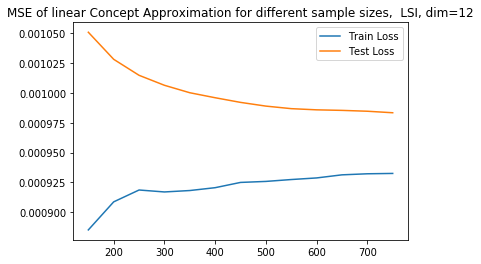

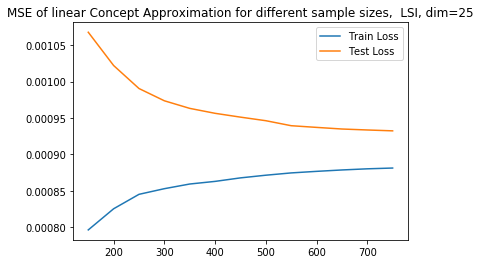

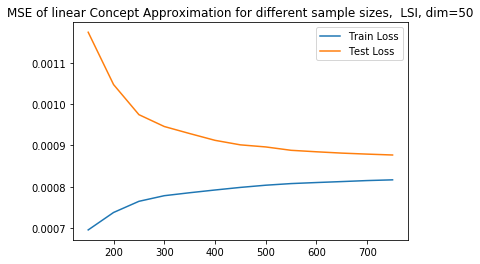

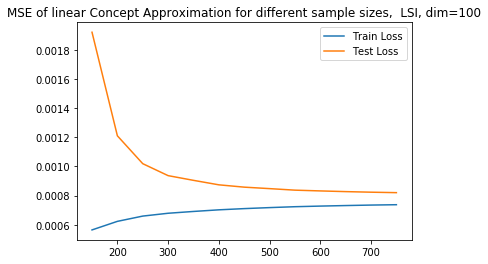

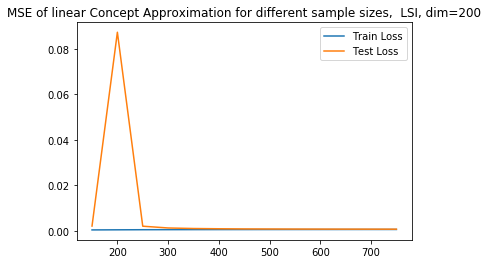

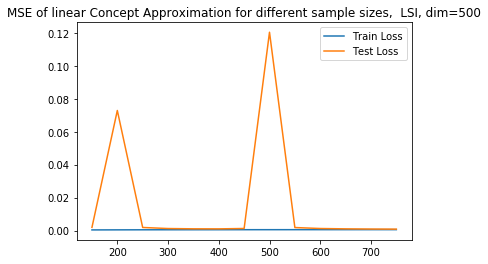

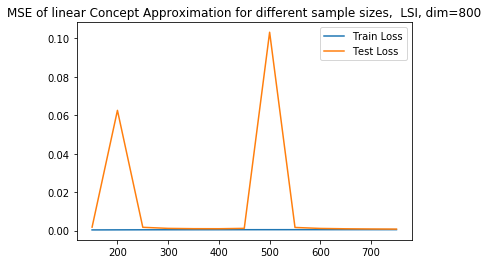

In [11]:

meta_train_scores = []
meta_test_scores = []

from sklearn import linear_model
import matplotlib.pylab as plt
from sklearn.metrics import mean_squared_error as mse
        
for dimension in dimensions:
    english_lsi_vecs = model_dict[dimension]["en_vecs"]
    english_lsi_vecs = model_dict[dimension]["fr_vecs"]
    
    for k in range(4):
        en_vecs_train, en_vecs_test, fr_vecs_train, fr_vecs_test = train_test_split(english_lsi_vecs, french_lsi_vecs, test_size=0.2)

        sample_sizes = [k*50 for k in range(3,16)]
        train_scores = []
        test_scores = []

        for num in sample_sizes:
            fr_to_en_clf = linear_model.LinearRegression()
            en_to_fr_clf = linear_model.LinearRegression()
            
            en_to_fr_clf.fit(en_vecs_train[:num], fr_vecs_train[:num])
            train_predictions = en_to_fr_clf.predict(en_vecs_train[:num])
            train_score = mse(train_predictions, fr_vecs_train[:num])

            test_predictions = en_to_fr_clf.predict(en_vecs_test)
            test_score = mse(test_predictions, fr_vecs_test)
            train_scores.append(train_score)
            test_scores.append(test_score)

        meta_train_scores.append(np.asarray(train_scores))
        meta_test_scores.append(np.asarray(test_scores))

    plt.plot(sample_sizes, np.mean(meta_train_scores, axis=0), label="Train Loss")  
    plt.plot(sample_sizes, np.mean(meta_test_scores, axis=0), label="Test Loss")
    plt.legend()
    plt.title("MSE of linear Concept Approximation for different sample sizes,  LSI, dim="+str(dimension))
    plt.show()
    
    


Going from 500, the MSE for the training and test dataset does not change much anymore. Now Train it with the full training data. 

- Just Train Classifier on whole training data as long as it is not too large

In [12]:

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model


for dimension in dimensions:
    
    english_lsi_vecs = model_dict[dimension]["en_vecs"] 
    french_lsi_vecs = model_dict[dimension]["fr_vecs"] 

    fr_to_en_clf = linear_model.LinearRegression()
    en_to_fr_clf = linear_model.LinearRegression()

    en_to_fr_clf.fit(english_lsi_vecs, french_lsi_vecs)
    fr_to_en_clf.fit(french_lsi_vecs, english_lsi_vecs)
    
    model_dict[dimension]["en_to_fr_clf"] = en_to_fr_clf
    model_dict[dimension]["fr_to_en_clf"] = fr_to_en_clf

**To do: Add Non-linear Regressors here**

So now we have obtained $\phi_{en\rightarrow fr}, \phi_{fr\rightarrow en}$ which provide us with mappings between the two different concept spaces of French and English Documents. What we would like to know now is how useful those functions actually are. 

## 4. Train Multilingual Document Representations
- Implement: CL-LSI, Improved CL-LSI

**Initialize MultiLingual Vocabulary to Train CL-LSI**

In [13]:
multiling_docs = []

for k in range(len(french_docs_preprocessed)):
    fr_doc = french_docs_preprocessed[k]
    en_doc = english_docs_preprocessed[k]
    multiling_docs.append(fr_doc+en_doc)
    

multiling_dictionary, multiling_corpus = create_corpus(multiling_docs)

print("Vocabulary:")
print("Unique Tokens: "+ str(len(multiling_dictionary)))


Vocabulary:
Unique Tokens: 6894


**Define tfidf for Multilingual Corpus, Train LSI embeddings for different dimensions**

In [14]:
from gensim import models
multiling_tfidf = models.TfidfModel(multiling_corpus)
multiling_corpus_tfidf = multiling_tfidf[multiling_corpus]

In [15]:
for dimension in dimensions:
    multi_lsi_model = models.LsiModel(multiling_corpus_tfidf, 
                            id2word=multiling_dictionary, 
                            num_topics=dimension)  
    
    model_dict[dimension]["mult"] = multi_lsi_model

**Create Vector Embeddings for the Documents**
- Embed French and English Documents Seperately

In [16]:
for dimension in dimensions:
    multiling_lsi_model = model_dict[dimension]["mult"]
    
    french_vecs = []
    for doc in french_docs_preprocessed:
        vec_bow = multiling_dictionary.doc2bow(doc)
        bow_tfidf = multiling_tfidf[vec_bow]
        vec_lsi = multiling_lsi_model[bow_tfidf]  
        vec_rep = np.asarray(list(zip(*vec_lsi))[1])
        french_vecs.append(vec_rep)

    english_vecs = []
    for doc in english_docs_preprocessed:
        vec_bow = multiling_dictionary.doc2bow(doc)
        bow_tfidf = multiling_tfidf[vec_bow]
        vec_lsi = multiling_lsi_model[bow_tfidf]  
        vec_rep = np.asarray(list(zip(*vec_lsi))[1])
        #This is here because of weird error, has to be fixed
        if vec_rep.shape[0]!= dimension:
             english_vecs.append(np.zeros(dimension))
        else:
            english_vecs.append(vec_rep)
        
    model_dict[dimension]["en_mult_vecs"] = english_vecs
    model_dict[dimension]["fr_mult_vecs"] = french_vecs

## 5. Evaluation - Interlingual Information Retrieval Performance

- Q1: How do the Concept Approximations compare to Multilingual Embeddings? 
- Q2: Which representation algorithm and which parameters are the best?
- Q3: Does a better classifier for concept approximation lead to better results? 



In [17]:
filtered_test_docs = []
for doc in test_documents:
    if len(doc["english"]) > 0 and len(doc["french"]) > 0:
        filtered_test_docs.append(doc)
        
fr_test_docs_preprocessed = [preprocessor_french.preprocess(doc["french"]) for doc in filtered_test_docs]
en_test_docs_preprocessed = [preprocessor_english.preprocess(doc["english"]) for doc in filtered_test_docs]

print("Number of Documents: " +str(len(fr_test_docs_preprocessed)))

Number of Documents: 967


In [18]:

for dimension in dimensions:
    english_lsi_model = model_dict[dimension]["en"]
    french_lsi_model = model_dict[dimension]["fr"]
    #multlingual_lsi_model = model_dict[dimension]["multi"]
    
    french_vecs = []
    for doc in fr_test_docs_preprocessed:
        vec_bow = french_dictionary.doc2bow(doc)
        bow_tfidf = french_tfidf[vec_bow]
        vec_lsi = french_lsi_model[bow_tfidf]  
        vec_rep = np.asarray(list(zip(*vec_lsi))[1])
        french_vecs.append(vec_rep)

    english_vecs = []
    for doc in en_test_docs_preprocessed:
        vec_bow = english_dictionary.doc2bow(doc)
        bow_tfidf = english_tfidf[vec_bow]
        vec_lsi = english_lsi_model[bow_tfidf]  
        vec_rep = np.asarray(list(zip(*vec_lsi))[1])
        #This is here because of weird error, has to be fixed
        if vec_rep.shape[0]!= dimension:
             english_vecs.append(np.zeros(dimension))
        else:
            english_vecs.append(vec_rep)
        
    model_dict[dimension]["en_test_vecs"] = english_vecs
    model_dict[dimension]["fr_test_vecs"] = french_vecs
        
    #Apply mapping into other concept space as well and save
    en_to_fr_clf = model_dict[dimension]["en_to_fr_clf"] 
    fr_to_en_clf = model_dict[dimension]["fr_to_en_clf"] 
    model_dict[dimension]["en_to_fr_test_vecs"] = en_to_fr_clf.predict(english_vecs)
    model_dict[dimension]["fr_to_en_test_vecs"] = fr_to_en_clf.predict(french_vecs)

**Create Test Vectors for Multilingual LSI**

In [19]:
for dimension in dimensions:
    multiling_lsi_model = model_dict[dimension]["mult"]
    
    french_vecs = []
    for doc in fr_test_docs_preprocessed:
        vec_bow = multiling_dictionary.doc2bow(doc)
        bow_tfidf = multiling_tfidf[vec_bow]
        vec_lsi = multiling_lsi_model[bow_tfidf]  
        vec_rep = np.asarray(list(zip(*vec_lsi))[1])
        french_vecs.append(vec_rep)

    english_vecs = []
    for doc in en_test_docs_preprocessed:
        vec_bow = multiling_dictionary.doc2bow(doc)
        bow_tfidf = multiling_tfidf[vec_bow]
        vec_lsi = multiling_lsi_model[bow_tfidf]  
        vec_rep = np.asarray(list(zip(*vec_lsi))[1])
        #This is here because of weird error, has to be fixed
        if vec_rep.shape[0]!= dimension:
             english_vecs.append(np.zeros(dimension))
        else:
            english_vecs.append(vec_rep)
        
    model_dict[dimension]["en_mult_test_vecs"] = english_vecs
    model_dict[dimension]["fr_mult_test_vecs"] = french_vecs
        


Best Mate Retrival Score is archieved for Dim=500. With a score of: 0.8934850051706308
Best Mate Retrival Score is archieved for Dim=500. With a score of: 0.8490175801447777
Best Mate Retrival Score is archieved for Dim=500. With a score of: 0.8262668045501551


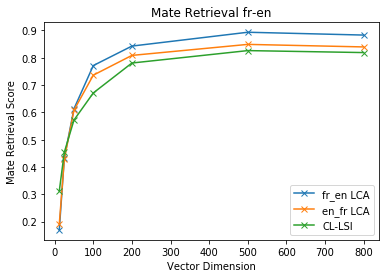

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

def mate_retrieval_plot(l1_vecs, l1_test_vecs, l2tol1_test_vecs, title,label):
    mate_retrieval_scores = []

    for dim in dimensions:

        en_vectors = model_dict[dim][l1_vecs]
        en_test_vectors = model_dict[dim][l1_test_vecs]
        fr_to_en_test_vectors = model_dict[dim][l2tol1_test_vecs]

        sim_matrix = cosine_similarity(en_test_vectors+en_vectors, fr_to_en_test_vectors)
        mate_scores = np.diagonal(cosine_similarity(en_test_vectors, fr_to_en_test_vectors))

        highest_similarity_score = np.max(sim_matrix, axis=0)
        mate_retrieval_score = np.sum(highest_similarity_score == mate_scores)/len(mate_scores)

        mate_retrieval_scores.append(mate_retrieval_score)

    max_value = np.max(mate_retrieval_scores)
    best_dim_ind = np.where(mate_retrieval_scores == max_value)[0][0]
    best_dim = dimensions[best_dim_ind]


    plt.plot(dimensions, mate_retrieval_scores, "-x",label=label)
    plt.xlabel('Vector Dimension')
    plt.ylabel('Mate Retrieval Score')
    plt.title("Mate Retrieval " +title)
    print("Best Mate Retrival Score is archieved for Dim="+str(best_dim)+\
             ". With a score of: "+str(max_value))

    
mate_retrieval_plot("en_vecs","en_test_vecs","fr_to_en_test_vecs", title= "fr-en",label="fr_en LCA")
mate_retrieval_plot("fr_vecs","fr_test_vecs","en_to_fr_test_vecs", title= "en-fr",label="en_fr LCA")
mate_retrieval_plot("en_mult_vecs","en_mult_test_vecs","fr_mult_test_vecs", title= "fr-en", label="CL-LSI")

plt.legend()